In [1]:
import os
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
os.environ['TORCH_USE_CUDA_DSA'] = '1'


In [2]:


from torch import nn
from torch.utils.data import Dataset, DataLoader, random_split
import torch
import numpy as np

import pandas as pd
import matplotlib.pyplot as plt



from utils import generate_bpr_dataset, generate_bpr_dataset_with_click_data
from evaluation import Evaluate
from bpr_mf import bprMf, bprMFDataloader, bprMFWithClickDebiasing

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [24]:
interactions = pd.read_csv('movielens_1m_ratings.csv')[["user", "item", "rating"]]
interactions["relevant"] = interactions["rating"].apply(lambda r: int(r >= 4))
zero_based_indexing = {v: K for K, v in enumerate(interactions["item"].unique())}
interactions["item"] = interactions["item"].map(zero_based_indexing)

## Developing a MF model based using BPR opt


Now we'll generalize the previous implementation using implicit feedback data and applying BPR (Bayesian personalized ranking) loss function, so that the model is capable of building personalzied rankings for users

### Step 1 : adapt training data for BPR


BPR expects implicit feedback data and relative ordering in the training dataset

In [5]:

zero_based_indexing = {v: K for K, v in enumerate(interactions["item"].unique())}
interactions["item"] = interactions["item"].map(zero_based_indexing)

bpr_df = generate_bpr_dataset(interactions)

### Step 2: Create a MF model using BPR loss function

In [6]:
data_bpr = bprMFDataloader(bpr_df)


# Calculate split lengths
train_len = int(0.7 * len(data_bpr))
test_len = len(data_bpr) - train_len


train_data, test_data = random_split(data_bpr, [train_len, test_len])



In [7]:


dataloader_bpr_train = DataLoader(train_data, batch_size=256, shuffle=True)
dataloader_bpr_test = DataLoader(test_data, batch_size=256, shuffle=True)

In [8]:

n_users = bpr_df.user.max() + 1
n_items = bpr_df.pos_item.max() + 1

In [9]:
n_users, n_items

(np.int64(6041), np.int64(3706))

In [10]:



model = bprMf(
                num_users=n_users,
                num_items=n_items,
                factors=50,
                reg_lambda=5e-4,
                n_epochs=10).to(device)

In [11]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

train_losses = model.fit(dataloader_bpr_train, optimizer)

In [12]:
train_losses

[0.47329927260086785,
 0.3436481025726021,
 0.33542926074854124,
 0.3342305378042874,
 0.3340217597433011,
 0.333979345010883,
 0.3339732900652342,
 0.3339746193759402,
 0.3339817884126718,
 0.33398793500091595]

In [13]:
test_loss = model.evaluate(dataloader_bpr_test)

In [14]:
test_loss

0.33495738476574133

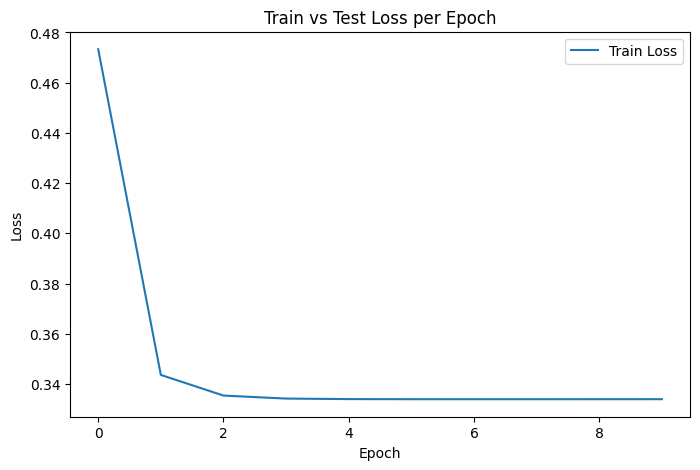

In [15]:
plt.figure(figsize=(8, 5))
plt.plot(train_losses, label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train vs Test Loss per Epoch')
plt.legend()
plt.show()

In [16]:
test_set = test_data.dataset.data

In [17]:
test_set

,user,pos_item,neg_item
0,1,0,1984
1,1,0,2190
2,1,0,119
3,1,1,3067
4,1,1,3575
...,...,...,...
3000622,6040,152,3482
3000623,6040,152,2575
3000624,6040,26,2439
3000625,6040,26,1206


In [18]:
relevant_set = test_set[["user"]].drop_duplicates()

In [19]:
relevant_set

,user
0,1
159,2
546,3
699,4
762,5
...,...
2995905,6036
2998569,6037
2999175,6038
2999235,6039


In [20]:
users = torch.tensor(list(test_data.dataset.data.user.drop_duplicates()), device=device)

In [21]:
candidates = torch.tensor(list(test_data.dataset.data.pos_item.drop_duplicates()), device=device)

In [22]:
%%time
item_recs = model.predict(users, candidates)[0]

Shape da saida do predict: 
torch.Size([6040, 3706])
CPU times: user 10.2 ms, sys: 5.01 ms, total: 15.3 ms
Wall time: 14.8 ms


In [25]:
evaluator = Evaluate(model, test_data, interactions, k=20)

Shape do item e usuario, respectivamente
torch.Size([3706])
torch.Size([6038])
Shape da saida do predict: 
torch.Size([6038, 3706])


In [43]:
evaluator.MAP_at_k()

0.06890706086847405

## Developing a BPR variant for click position debiasing

In [27]:
interactions["click"] = np.random.randint(0, 20, size=len(interactions))

In [28]:
interactions

,user,item,rating,relevant,click
0,1,0,5,1,14
1,1,1,3,0,7
2,1,2,3,0,9
3,1,3,4,1,9
4,1,4,5,1,15
...,...,...,...,...,...
1000204,6040,772,1,0,13
1000205,6040,1106,5,1,12
1000206,6040,365,5,1,10
1000207,6040,152,4,1,3


In [29]:

bpr_df_click = generate_bpr_dataset_with_click_data(interactions)

In [30]:
bpr_df_click

,user,pos_item,click_position,neg_item
0,1,0,14,3431
1,1,0,14,2963
2,1,0,14,2641
3,1,1,7,2077
4,1,1,7,2500
...,...,...,...,...
3000622,6040,152,3,1045
3000623,6040,152,3,3668
3000624,6040,26,5,1595
3000625,6040,26,5,912


In [31]:
from bpr_mf import bprMFLClickDebiasingDataloader, bprMFWithClickDebiasing

In [32]:
data_bpr = bprMFLClickDebiasingDataloader(bpr_df_click)


train_len = int(0.7 * len(data_bpr))
test_len = len(data_bpr) - train_len


train_data, test_data = random_split(data_bpr, [train_len, test_len])



dataloader_bpr_train = DataLoader(train_data, batch_size=256, shuffle=True)
dataloader_bpr_test = DataLoader(test_data, batch_size=256, shuffle=True)

In [33]:
n_users = bpr_df_click.user.max() + 1
n_items = bpr_df_click.pos_item.max() + 1

In [34]:
model = bprMFWithClickDebiasing(
                num_users=n_users,
                num_items=n_items,
                factors=50,
                reg_lambda=1e-3,
                n_epochs=10).to(device)


optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)


In [35]:

train_losses = model.fit(dataloader_bpr_train, optimizer)

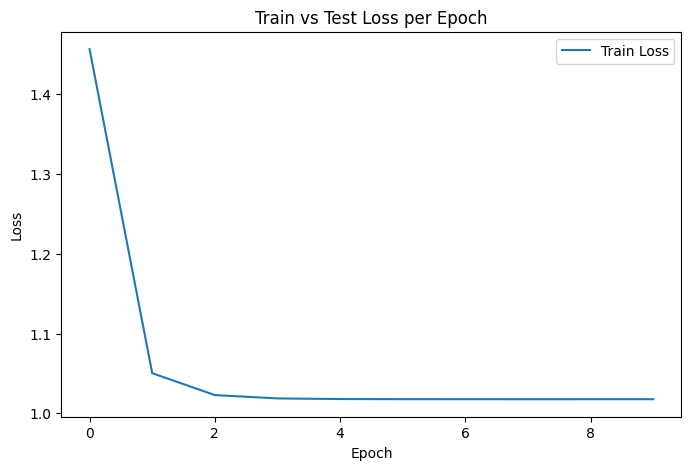

In [36]:
plt.figure(figsize=(8, 5))
plt.plot(train_losses, label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train vs Test Loss per Epoch')
plt.legend()
plt.show()

In [37]:
test_loss = model.evaluate(dataloader_bpr_test)

In [38]:
test_loss

1.0192776263217747

In [39]:
evaluator = Evaluate(model, test_data, interactions, k=20)

Shape do item e usuario, respectivamente
torch.Size([3706])
torch.Size([6038])
Shape da saida do predict: 
torch.Size([6038, 3706])


In [41]:
evaluator.MAP_at_k()

0.06890706086847405